# Week 3 Assignment
## Overview
The following is a simple exploratory data analysis of the GapMinder data set as part of the Coursera Data Management and Visualization course.  In this analysis I would like to examine the relationship between the economic well-being of a society and the level of democratization.

## About the Data
The data for this analysis comes from a subset of the GapMider project data.  In this section I will examine the variables I am interested in more detail.

### Income per Person
In order to measure the economic well-being I will be using GDP per capita data.  This originally came from the World Bank.  It is gross domestic product divided by midyear population. GDP is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources.  The data are in constant 2000 US Dollars.  The GapMinder data set that I will be analyzing is the 2010 GDP per capita.

### Democracy Score
The democracy score comes from the Polity IV project.  It is a summary measure of a country's democratic and free nature. -10 is the lowest value, 10 the highest.  The GapMinder data set that I will analyzing is the polity score for 2009.  To get a feel for this data take a look at the following figure provided by the Polity IV project authors:

![polity categories](http://www.systemicpeace.org/polity/demmap13.jpg)

### Democracy Categories
Since the democracy score ranges from -10 to 10 there will be 21 values.  This will be a bit unruly so I will create a new variable using the democracy categories detailed in the map legend above.

### Continents
I have also created a data set that maps each country into a continent.  This is done so I can take a look at a geographical variable to see if it is meaningful to include or not.

## Data Mangement
I begin by importing the libraries needed for the analysis:

In [1]:
%matplotlib inline
# Import libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Now I have python parse the csv file and print out some basic statistics about the data frame (df):

In [2]:
# Read in the GapMinder Data
print('Reading in GapMinder data')
df = pd.read_csv('gapminder.csv', low_memory=False)
# Print some basic statistics about the GapMinder data
print('Number of observations: '+ str(len(df)) +' (rows)')
print('Number of variables: '+ str(len(df.columns)) +' (columns)')

Reading in GapMinder data
Number of observations: 213 (rows)
Number of variables: 16 (columns)


There are 213 observations with 16 variables in the data frame.  I have created a dataset that maps the countries in the GapMinder data set to their individual continents.  I will pull in this data and print out some basic statistics about that data frame:

In [3]:
print('Reading in continent data')
continents = pd.read_csv('gapminder-continents.csv', low_memory=False)
# Print some basic statistics about the continents
print('Number of observations: '+ str(len(continents)) +' (rows)')
print('Number of variables: '+ str(len(continents.columns)) +' (columns)')

Reading in continent data
Number of observations: 213 (rows)
Number of variables: 2 (columns)


Now that I have both data frames I will merge them together:

In [4]:
# Merge the two dataframes
print('Merging GapMinder and continent data')
df = pd.merge(df, continents, left_on='country', right_on='country')
# Print some updated basic statistics
print('Number of observations: '+ str(len(df)) +' (rows)')
print('Number of variables: '+ str(len(df.columns)) +' (columns)')

Merging GapMinder and continent data
Number of observations: 213 (rows)
Number of variables: 17 (columns)


There are 2013 observations but are now 17 variables.  I will need to change the object types as a first step of data wrangling:

In [5]:
# Change the data type for variables of interest
df['polityscore'] = df['polityscore'].convert_objects(convert_numeric=True)
df['incomeperperson'] = df['incomeperperson'].convert_objects(convert_numeric=True)

I want to see how many missing observations there are in the variables of interest:

In [6]:
# Print out the counts of valid and missing rows
print ('Countries with a Democracy Score: ' + str(df['polityscore'].count()) + ' out of ' + str(len(df)) + ' (' + str(len(df) - df['polityscore'].count()) + ' missing)')
print ('Countries with a GDP Per Capita: ' + str(df['incomeperperson'].count()) + ' out of ' + str(len(df)) + ' (' + str(len(df) - df['incomeperperson'].count()) + ' missing)')

Countries with a Democracy Score: 161 out of 213 (52 missing)
Countries with a GDP Per Capita: 190 out of 213 (23 missing)


I need to have a set of data with both variables of interest so I will subset the data frame:

In [7]:
# Get the rows not missing a value
print('Dropping rows with missing democracy score and per capita GDP')
subset = df[np.isfinite(df['polityscore'])]
subset = subset[np.isfinite(subset['incomeperperson'])]
print('Number of observations: '+ str(len(subset)) +' (rows)')
print('Number of variables: '+ str(len(subset.columns)) +' (columns)')

Dropping rows with missing democracy score and per capita GDP
Number of observations: 155 (rows)
Number of variables: 17 (columns)


155 of the 213 records have complete data.  Now I will drop the unneeded variables from the merged data frame:

In [8]:
# Drop unneeded columns
print('Dropping unneeded variables')
drops = ['country', 'alcconsumption', 'armedforcesrate', 'breastcancerper100th', 'co2emissions', 'femaleemployrate', 'hivrate', 'internetuserate', 'lifeexpectancy', 'oilperperson', 'relectricperperson', 'suicideper100th', 'employrate', 'urbanrate']
subset.drop(drops,inplace=True,axis=1)
# Print more statistics
print('Number of observations: '+ str(len(subset)) +' (rows)')
print('Number of variables: '+ str(len(subset.columns)) +' (columns)')

Dropping unneeded variables
Number of observations: 155 (rows)
Number of variables: 3 (columns)


Now I will create my new variable for the democracy score categories.  I will do this by defining a function and then using that function to create the new variable:

In [9]:
# This function converts the polity score to a category
def convert_polityscore_to_category(score):
    if score == 10:
        return('1 - Full Democracy')
    elif score > 5:
        return('2 - Democracy')
    elif score > 0:
        return ('3 - Open Anocracy')
    elif score > -6:
        return ('4 - Closed Anocracy')
    else:
        return('5 - Autocracy')

# Now we can use the function to create the new variable
subset['democracy'] = subset['polityscore'].apply(convert_polityscore_to_category)
subset['democracy'] = subset['democracy'].astype('category')

I also need to make a change to the GDP per capita.  Since GDP per person is a continuous varible I will need to create a discrete one. For this assignment I will create quintiles and quartiles:

In [10]:
# Create per capita GDP quintiles
print('Creating GDP per capita quintiles')
subset['incomequintiles'] = pd.cut(subset['incomeperperson'], 5, labels=['1 - Lowest  (0% to 20%)','2 - Second  (20% to 40%)','3 - Middle  (40% to 60%)','4 - Fourth  (60% to 80%)','5 - Highest (80% to 100%)'])
subset['incomequintiles'] = subset['incomequintiles'].astype('category')
# Create per capita GDP quartiles
print('Creating GDP per capita quartiles')
subset['incomequartiles'] = pd.cut(subset['incomeperperson'], 4, labels=['1 -  0% to 25%','2 - 25% to 50%','3 - 50% to 75%','4 - 75% to 100%'])
subset['incomequartiles'] = subset['incomequartiles'].astype('category')
print('Number of observations: '+ str(len(subset)) +' (rows)')
print('Number of variables: '+ str(len(subset.columns)) +' (columns)')

Creating GDP per capita quintiles
Creating GDP per capita quartiles
Number of observations: 155 (rows)
Number of variables: 6 (columns)


## Exploratory Data Analysis

### Economic Well-Being and Level of Democracy by Continent

I want to get a sense of where the distribution of levels of democracy over the continents.  Where are most of the full democracies?  Where are the autocracies?  Is geography a meaningful variable to include?  

First let's start off with what is the distribution of countries by continent in the data set:

In [11]:
print('Countries by Continent')
country_counts = subset.groupby('continent').size()
print(country_counts)

Countries by Continent
continent
Africa                    49
Asia                      37
Australia and Oceania      5
Europe                    39
North America             14
South America             11
dtype: int64


Most of the countries are from Africa and Europe.  There is no suprises here.  
#### Level of Democracy by Continent
Now let's look at which continents have the democracies:

In [12]:
print('Democracies by Continent')
subset2 = subset[(subset['democracy'] == '1 - Full Democracy') | (subset['democracy'] == '2 - Democracy')]
democracy_counts = subset2.groupby('continent').size()
print(democracy_counts)

Democracies by Continent
continent
Africa                    17
Asia                      13
Australia and Oceania      3
Europe                    35
North America             12
South America              9
dtype: int64


Most of the democracies are in Europe, followed by Africa and North America.  Now I want to look at which continent has the highest share of countries that are democracies:  

In [13]:
print('Percent of Democracies by Continent')
democracy_percent = (democracy_counts / country_counts)*100
print(democracy_percent)

Percent of Democracies by Continent
continent
Africa                    34.693878
Asia                      35.135135
Australia and Oceania     60.000000
Europe                    89.743590
North America             85.714286
South America             81.818182
dtype: float64


Europe has the highest concentration (about 90%) followed by North America (85%).  Asia and Africa had the lowest concentrations (both roughly 35%).

In [14]:
print('Autocracies by Continent')
subset3 = subset[(subset['democracy'] == '5 - Autocracy')]
autocracy_counts = subset3.groupby('continent').size()
print(autocracy_counts)

Autocracies by Continent
continent
Africa            4
Asia             13
Europe            2
North America     1
dtype: int64


Asia has 13 countries that are autocracies.  South America and Australia and Oceania are not found in this list.

In [15]:
print('Percent of Autocracies by Continent')
autocracy_percent = (autocracy_counts / country_counts)*100
print(autocracy_percent)

Percent of Autocracies by Continent
continent
Africa                     8.163265
Asia                      35.135135
Australia and Oceania           NaN
Europe                     5.128205
North America              7.142857
South America                   NaN
dtype: float64


I want to see this data displayed as a crosstab:

In [16]:
ct1 = pd.crosstab(subset['continent'], subset['democracy'])
print('The Number of Countries by Continent and Level of Democracy')
print(ct1)

The Number of Countries by Continent and Level of Democracy
democracy               1 - Full Democracy  2 - Democracy  3 - Open Anocracy  \
continent                                                                      
Africa                                   1             16                  8   
Asia                                     3             10                  6   
Australia and Oceania                    2              1                  1   
Europe                                  20             15                  2   
North America                            4              8                  1   
South America                            2              7                  1   

democracy               4 - Closed Anocracy  5 - Autocracy  
continent                                                   
Africa                                   20              4  
Asia                                      5             13  
Australia and Oceania                     1            

In [17]:
pt1 = (ct1/len(subset))*100
print('The Percent of Countries by Continent and Level of Democracy')
print(pt1)

The Percent of Countries by Continent and Level of Democracy
democracy               1 - Full Democracy  2 - Democracy  3 - Open Anocracy  \
continent                                                                      
Africa                            0.645161      10.322581           5.161290   
Asia                              1.935484       6.451613           3.870968   
Australia and Oceania             1.290323       0.645161           0.645161   
Europe                           12.903226       9.677419           1.290323   
North America                     2.580645       5.161290           0.645161   
South America                     1.290323       4.516129           0.645161   

democracy               4 - Closed Anocracy  5 - Autocracy  
continent                                                   
Africa                            12.903226       2.580645  
Asia                               3.225806       8.387097  
Australia and Oceania              0.645161       0.00

#### Economic Well-Being by Continent
From previous experience with these types of measures I have an sense of what these numbers will be but want to examine this data set:

In [18]:
print('GDP Statistics by Continent')
gdp_mean = subset.groupby('continent')['incomeperperson'].agg([np.mean, np.std, np.median, len])
print(gdp_mean)

GDP Statistics by Continent
                                mean           std       median  len
continent                                                           
Africa                   1282.323323   1905.397493   432.226337   49
Asia                     6626.390845  10354.906574  1525.780116   37
Australia and Oceania    8829.433594  10874.284074  2230.676374    5
Europe                  13150.136846  11939.924136  7381.312751   39
North America            7863.006553  10619.249438  4272.107945   14
South America            4419.465882   3248.702577  3233.423780   11


I personally feel the median is the measure to look at in the preceeding table.  Median per capita GDP is highest in Europe followed by North America and is horrifically low in Africa.

### Economic Well-Being by Level of Democracy
#### Approach 1: GDP Per Capita Quintiles by Level of Democracy
Now that I have a sense of the relationship between the level of democracy and the continent I will examine the relationship between economic well-being and level of democracy.  I will begin with an examination of GDP quintiles by level of democracy:

In [19]:
# Create crosstabs
ct2 = pd.crosstab(subset['incomequintiles'], subset['democracy'])
print('The Number of Countries by Income Quintile and Level of Democracy')
print(ct2)

The Number of Countries by Income Quintile and Level of Democracy
democracy                  1 - Full Democracy  2 - Democracy  \
incomequintiles                                                
1 - Lowest  (0% to 20%)                     7             53   
2 - Second  (20% to 40%)                    9              1   
3 - Middle  (40% to 60%)                    2              2   
4 - Fourth  (60% to 80%)                    9              1   
5 - Highest (80% to 100%)                   5              0   

democracy                  3 - Open Anocracy  4 - Closed Anocracy  \
incomequintiles                                                     
1 - Lowest  (0% to 20%)                   19                   25   
2 - Second  (20% to 40%)                   0                    1   
3 - Middle  (40% to 60%)                   0                    0   
4 - Fourth  (60% to 80%)                   0                    0   
5 - Highest (80% to 100%)                  0                    1   

d

In [20]:
pt2 = (ct2/len(subset))*100
print('The Percent of Countries by Income Quintile and Level of Democracy')
print(pt2)

The Percent of Countries by Income Quintile and Level of Democracy
democracy                  1 - Full Democracy  2 - Democracy  \
incomequintiles                                                
1 - Lowest  (0% to 20%)              4.516129      34.193548   
2 - Second  (20% to 40%)             5.806452       0.645161   
3 - Middle  (40% to 60%)             1.290323       1.290323   
4 - Fourth  (60% to 80%)             5.806452       0.645161   
5 - Highest (80% to 100%)            3.225806       0.000000   

democracy                  3 - Open Anocracy  4 - Closed Anocracy  \
incomequintiles                                                     
1 - Lowest  (0% to 20%)            12.258065            16.129032   
2 - Second  (20% to 40%)            0.000000             0.645161   
3 - Middle  (40% to 60%)            0.000000             0.000000   
4 - Fourth  (60% to 80%)            0.000000             0.000000   
5 - Highest (80% to 100%)           0.000000             0.645161   



I observe that most countries are in the lowest gdp per capita quintile.  34% of the countries in the data set are both democracies and are in the lowest per capita GDP quintile.  Most of the countries in the highest quintile are full democracies.

#### Approach 2: GDP Per Capita Quartiles by Level of Democracy

In [21]:
ct3 = pd.crosstab(subset['incomequartiles'], subset['democracy'])
print('The Number of Countries by Income Quartile and Level of Democracy')
print(ct3)

The Number of Countries by Income Quartile and Level of Democracy
democracy        1 - Full Democracy  2 - Democracy  3 - Open Anocracy  \
incomequartiles                                                         
1 -  0% to 25%                    9             53                 19   
2 - 25% to 50%                    8              2                  0   
3 - 50% to 75%                    9              2                  0   
4 - 75% to 100%                   6              0                  0   

democracy        4 - Closed Anocracy  5 - Autocracy  
incomequartiles                                      
1 -  0% to 25%                    26             16  
2 - 25% to 50%                     0              2  
3 - 50% to 75%                     0              1  
4 - 75% to 100%                    1              1  


In [22]:
pt3 = (ct3/len(subset))*100
print('The Percent of Countries by Income Quartile and Level of Democracy')
print(pt3)

The Percent of Countries by Income Quartile and Level of Democracy
democracy        1 - Full Democracy  2 - Democracy  3 - Open Anocracy  \
incomequartiles                                                         
1 -  0% to 25%             5.806452      34.193548          12.258065   
2 - 25% to 50%             5.161290       1.290323           0.000000   
3 - 50% to 75%             5.806452       1.290323           0.000000   
4 - 75% to 100%            3.870968       0.000000           0.000000   

democracy        4 - Closed Anocracy  5 - Autocracy  
incomequartiles                                      
1 -  0% to 25%             16.774194      10.322581  
2 - 25% to 50%              0.000000       1.290323  
3 - 50% to 75%              0.000000       0.645161  
4 - 75% to 100%             0.645161       0.645161  


Breaking the data out by quartile does not produce a significantly different picture than the quintiles.  Most are in the lowest quintile. 6 of the 8 countries in the top income quartiles are full democracies.

#### Approach Number 3: Average Well-Being by Level of Democracy

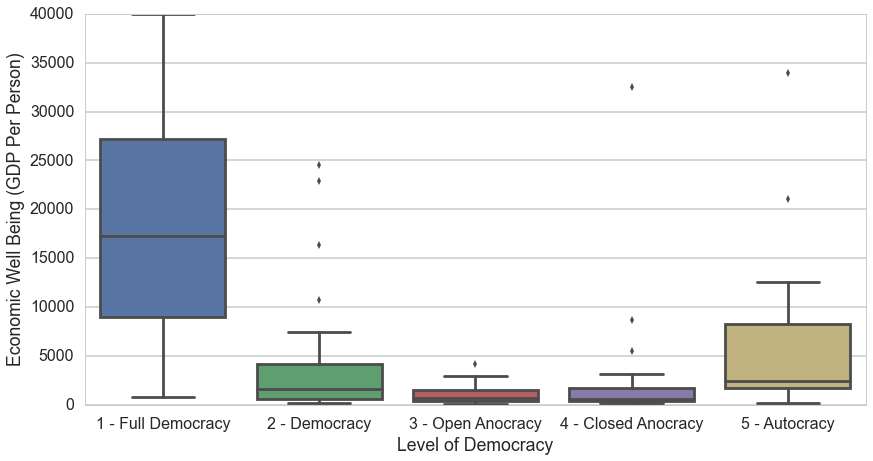

In [23]:
sns.set_style("whitegrid")
sns.set_context("poster")
plt.figure(figsize=(14, 7))
sns.boxplot(x="democracy", y="incomeperperson", data=subset)
plt.ylabel('Economic Well Being (GDP Per Person)')
plt.xlabel('Level of Democracy')

I personally find the above visaulization very impactful.  One observes the higher level of economic well-being associated with the full democracy.  One also observes there are two outliers in the autocracy that are higher than the full democracy.  It might be interesting to look into these two cases as they are contrary to the working assumption of this project.  Here is the same data presented in tabular format:

In [24]:
print('GDP Statistics by Level of Democracy')
gdp_mean2 = subset.groupby('democracy')['incomeperperson'].agg([np.mean, np.std, np.median, len])
print(gdp_mean2)

GDP Statistics by Level of Democracy
                             mean           std        median  len
democracy                                                         
1 - Full Democracy   19290.403182  11585.710266  17222.013829   32
2 - Democracy         3424.612984   4891.795845   1621.177078   57
3 - Open Anocracy     1167.128903   1112.912373    668.547943   19
4 - Closed Anocracy   2472.575659   6298.382567    591.067944   27
5 - Autocracy         6113.909582   8416.873490   2385.184105   20
